# **Machine Learning Final Project:** Death Rate and Average Temperature in New Mexico
*Authors: Abdulmuiz Adekomi, Marina Lewis, Abdulahi Raji, Nicolaas Wooters*

Here is the code for our project where we aim to predict average temperature and death rates in New Mexico based on a variety of meteorological data. More detailed comments on the code is under 'Predicting Death Rate'.

## Predicting Average Temperature

### GRU Model

Import all necessary modules & packages

In [18]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import joblib
import os

SEED = 42424
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Load the data

In [19]:
# Load the data sets and combine them into a single usable dataframe called data series
data_series = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_avg_temp.csv')

# rename columns to be more descriptive
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)

# append to the dataframe
data_cool_degree = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_max_temp.csv')
data_min_temp = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_min_temp.csv')
data_palmer_z = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_palmer_z.csv')
data_pdsi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_pdsi.csv')
data_phdi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_phdi.csv')
data_pmdi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_pmdi.csv')
data_precipitation = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_precipitation.csv')

# Append columns to the data series
data_series['cool_degree_days'] = data_cool_degree['Value']
data_series['heat_degree_days'] = data_heat_degree['Value']
data_series['max_temp'] = data_max_temp['Value']
data_series['min_temp'] = data_min_temp['Value']
data_series['palmer_z'] = data_palmer_z['Value']
data_series['pdsi'] = data_pdsi['Value']
data_series['phdi'] = data_phdi['Value']
data_series['pmdi'] = data_pmdi['Value']
data_series['precipitation'] = data_precipitation['Value']


Visualizations for our parameters

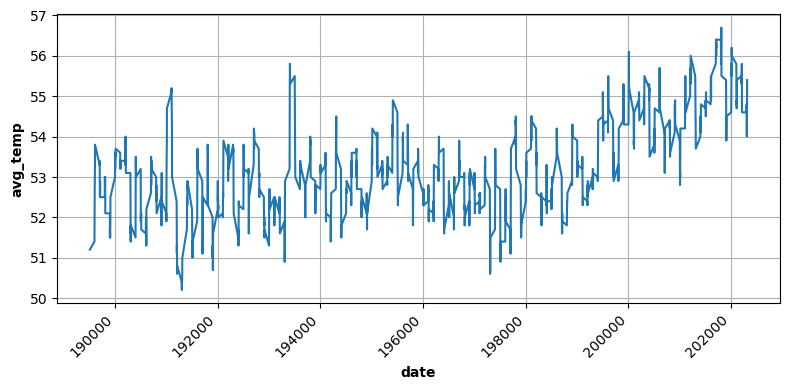

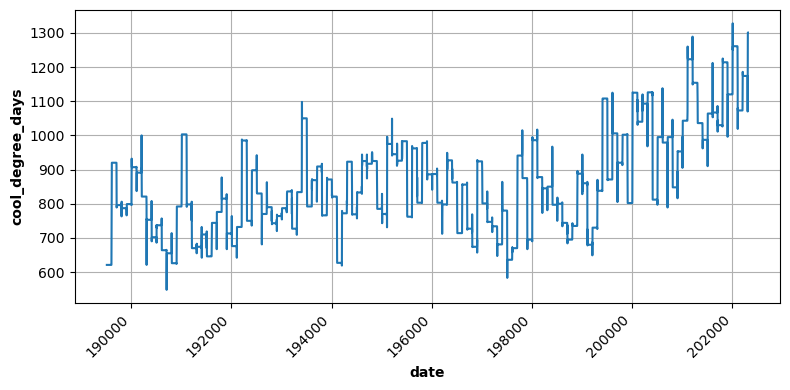

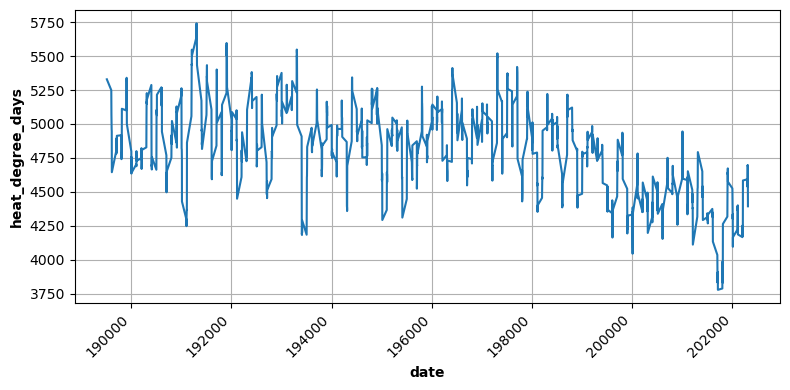

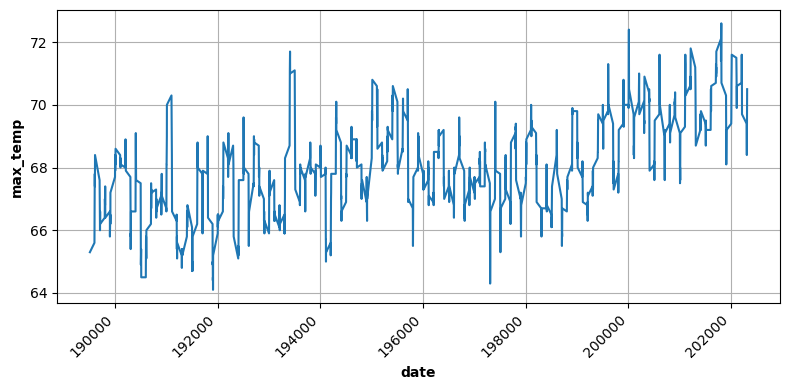

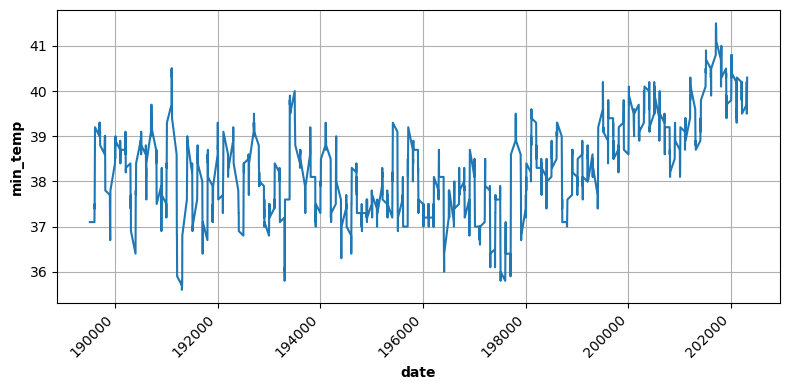

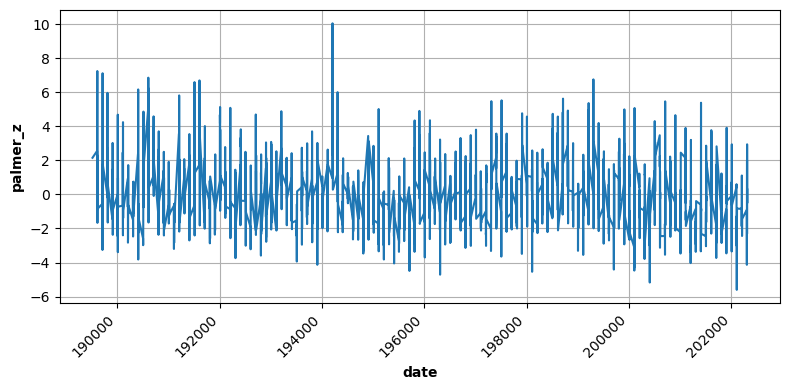

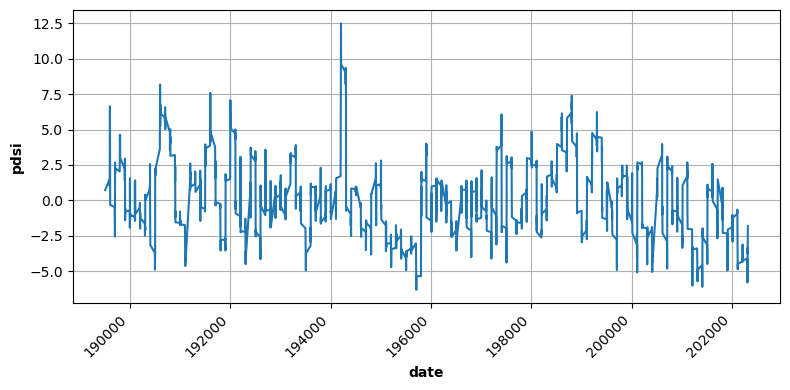

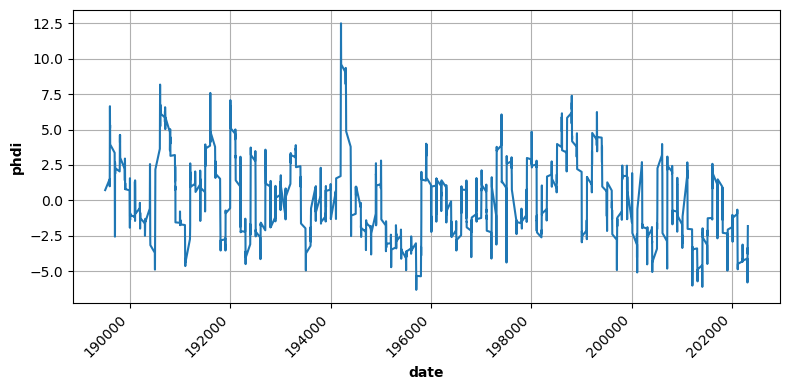

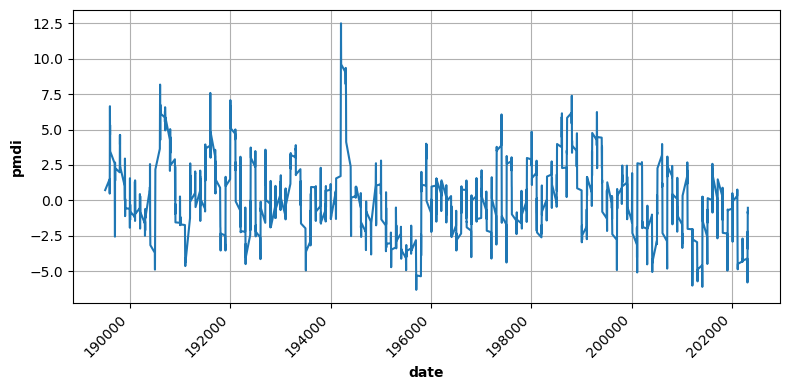

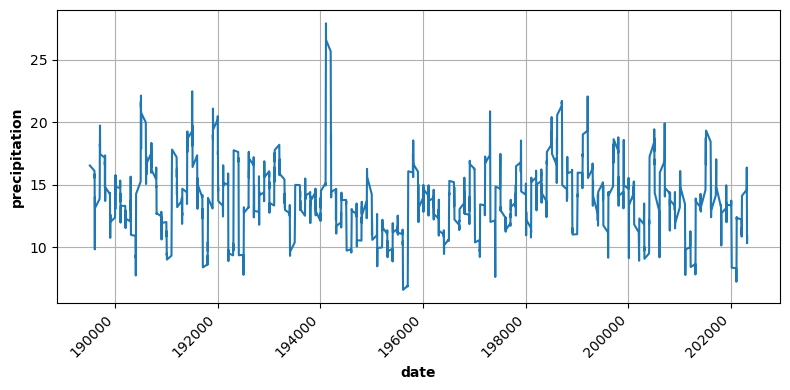

In [20]:
def plot_columns(df, x_col='date', figsize=(8, 4), dpi=100):
    
    for col in df.columns:
        if col != x_col:  # Skip the x-column itself
            plt.figure(figsize=figsize, dpi=dpi)
            plt.plot(df[x_col], df[col], label=col)
            plt.xlabel(x_col, fontdict={'weight': 'bold'})
            plt.ylabel(col, fontdict={'weight': 'bold'})
            # plt.title(f"{col} Over Time")
            # plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
plot_columns(data_series)

/var/folders/ds/s8gbbjqx4pbct0mlwnl6j9sr0000gn/T/ipykernel_61794/1951479902.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data_to_plot, diagonal='kde', ax=ax)


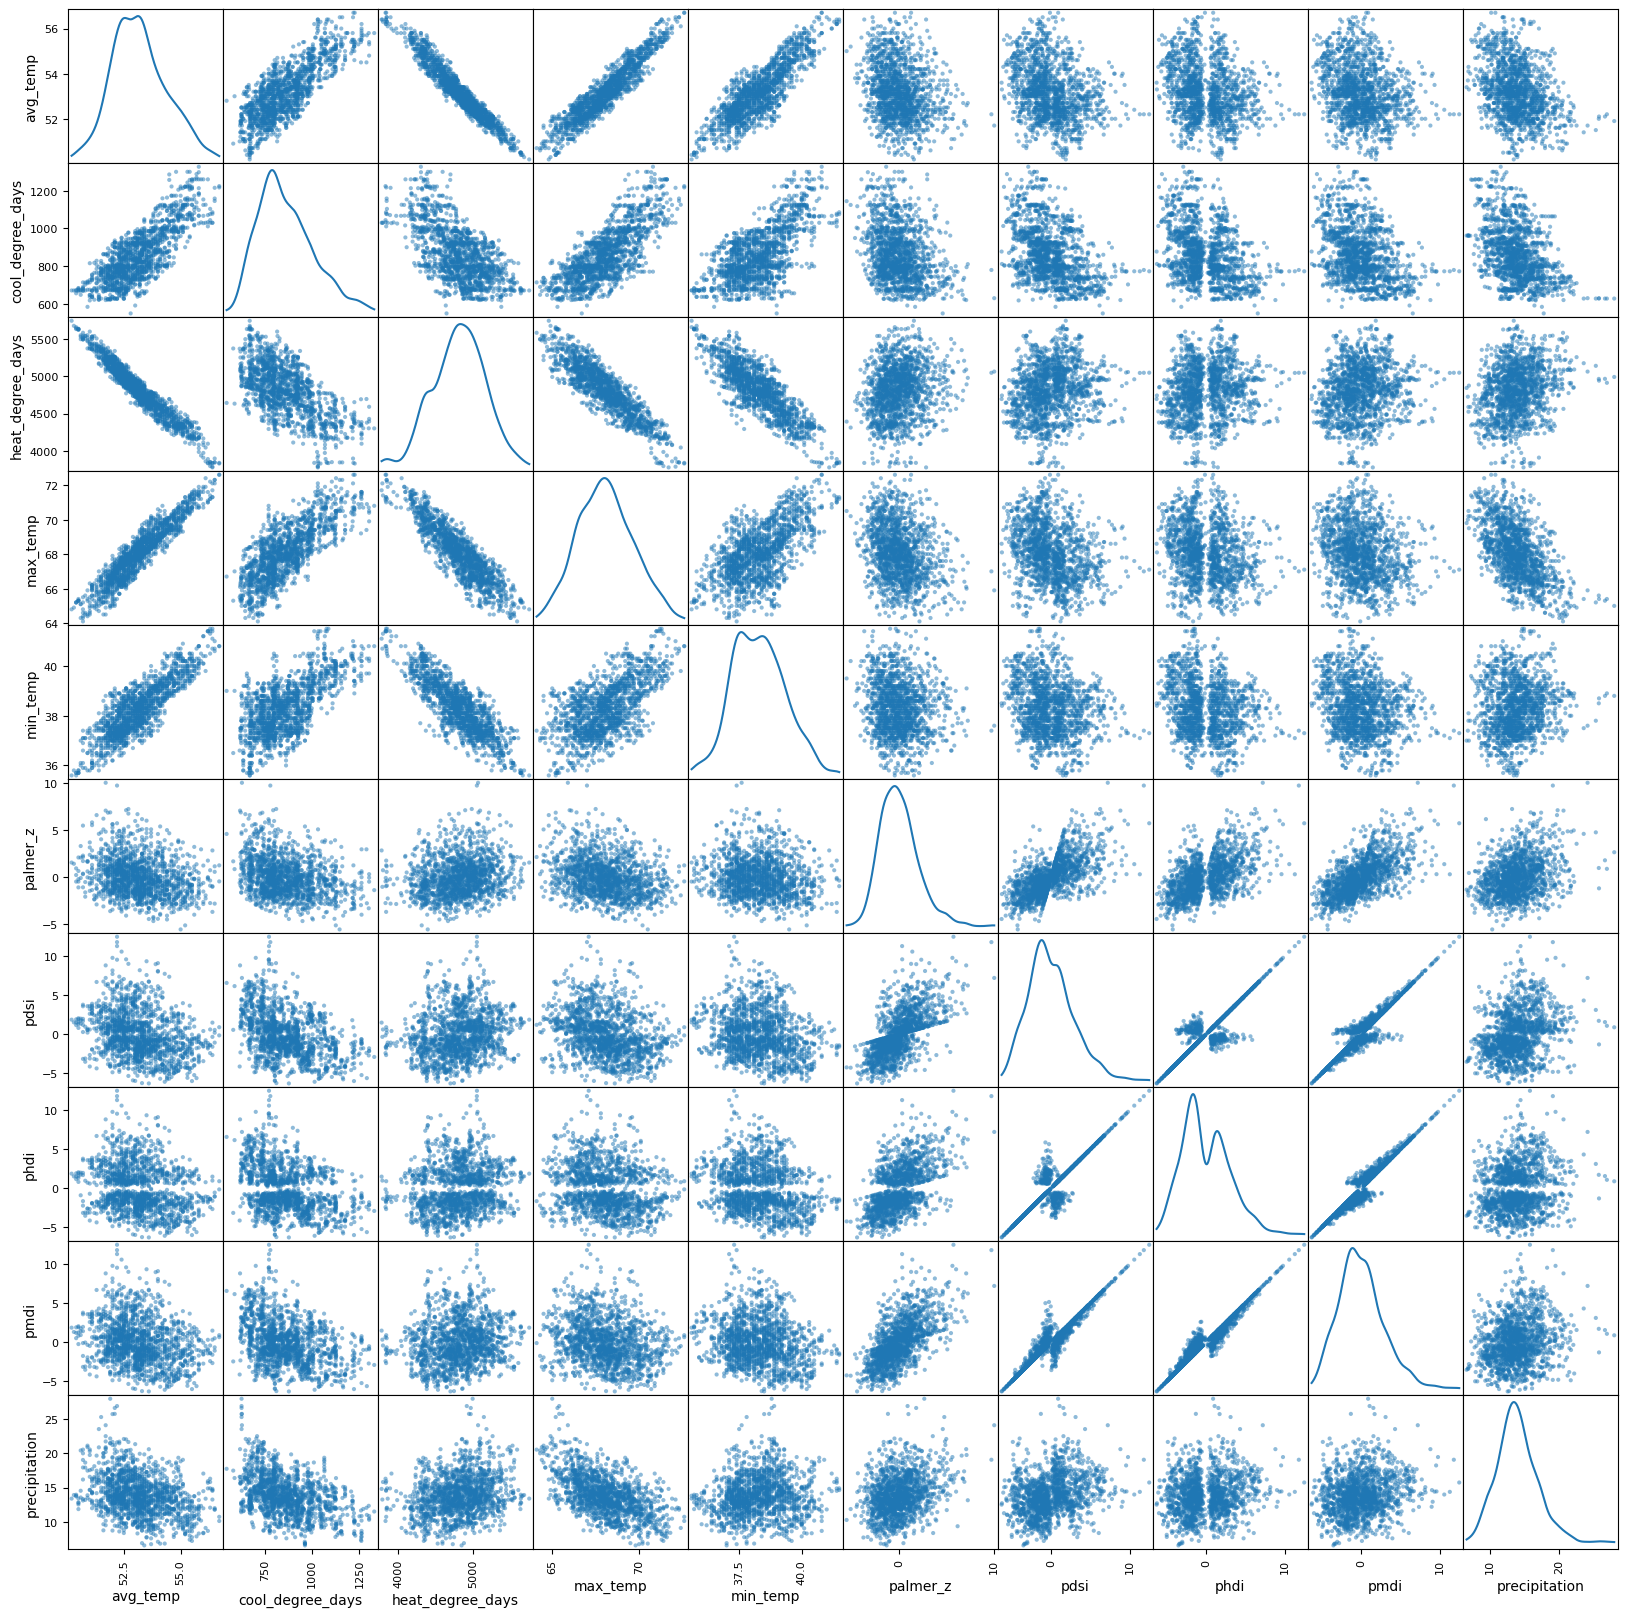

In [21]:
data_to_plot = data_series.drop(columns=['date'])  # Exclude 'date' column
fig, ax = plt.subplots(figsize=(20, 20))
pd.plotting.scatter_matrix(data_to_plot, diagonal='kde', ax=ax)
plt.show()

Scale the data

In [22]:
# Convert dataframe to numpy array
avg_temp = data_series['avg_temp'].to_numpy()
data_series.drop(columns=['avg_temp'], inplace=True)

# Scale the data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(data_series[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days']])

robust_scaler = RobustScaler()
x_train_scaled = np.append(x_train_scaled, robust_scaler.fit_transform(data_series[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)

minmax_scaler = MinMaxScaler()
x_train_scaled = np.append(x_train_scaled, minmax_scaler.fit_transform(data_series[['precipitation']]), axis=1)

joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(robust_scaler, 'robust_scaler.joblib')
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')

# Expand first dim
x_train_scaled = np.expand_dims(x_train_scaled, axis=0)
y_train = np.expand_dims(avg_temp, axis=0)

print(x_train_scaled.shape)

(1, 1537, 9)


Here, we train the GRU model

In [23]:
# Train the GRU model
model_gru = Sequential(
    [
        GRU(20, activation='relu', 
        input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])),
        Dense(1)
    ]
)

model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(x_train_scaled, y_train, epochs=1000, batch_size=1,verbose=0)

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We want to forecast our average temperature predictions, to do this, we treat each parameter as a target variable with its own model. Each model specializes in learning the unique characteristics of each parameter (variations in precipitation, temperature, etc.).

In [24]:
# Predict the temperature by regressing the other features and then predicting average temperature
parameters = ['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
models = {}
scalers = {}

date = data_series['date'].to_numpy()
date_splice = np.zeros((len(date), 2))

param_models = []

for i, element in enumerate(date):
    # print(element)
    # Splice this string to get year and month
    date_splice[i,0] = int(str(element)[0:4])
    date_splice[i,1] = int(str(element)[5:7])

for param in parameters:
    print(f"PARAM", param)
    y = data_series[param].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False, random_state=SEED)

    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # input_shape=(2,)
        Dense(1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=0)

    # Save model
    param_models.append(model)

PARAM max_temp


/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PARAM min_temp
PARAM cool_degree_days
PARAM heat_degree_days
PARAM palmer_z
PARAM pdsi
PARAM phdi
PARAM pmdi
PARAM precipitation


Here, we predict our parameters (temperature, precipitation, etc.) for the next 60 years on a monthly basis using the pre-trained regression models.

In [25]:
# Prediction of the average temperature
# Using trained models to predict the parameters and then use those predictions as input for the GRU model

years = 60  # Years in the future
date_predict = np.array([[2024 + i // 12, 1 + i % 12] for i in range(years * 12)])  # Generate year-month pairs

param_predicts = np.zeros((len(parameters), years * 12))

# Predict the parameters using the trained models
for k, model in enumerate(param_models):
    for i in range(years * 12):
        param_predicts[k, i] = model.predict(date_predict[i].reshape(1, -1), verbose=0).flatten()

# Generate a year-month vector
yearmonth_vec = date_predict[:, 0] * 100 + date_predict[:, 1]

columns = ['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
df_predict = pd.DataFrame(param_predicts.T, columns=columns)

# Normalize the data with the same scalers
predict_scaled = std_scaler.transform(df_predict[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days']])
predict_scaled = np.append(predict_scaled, robust_scaler.transform(df_predict[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
predict_scaled = np.append(predict_scaled, minmax_scaler.transform(df_predict[['precipitation']]), axis=1)

# Summarize output
print(f"Normalized Data Shape: {predict_scaled.shape}")
print(f"Sample of Normalized Data (first 5 rows):\n{pd.DataFrame(predict_scaled[:5])}")


/var/folders/ds/s8gbbjqx4pbct0mlwnl6j9sr0000gn/T/ipykernel_61794/384566302.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_predicts[k, i] = model.predict(date_predict[i].reshape(1, -1), verbose=0).flatten()


Normalized Data Shape: (720, 9)
Sample of Normalized Data (first 5 rows):
          0         1         2         3         4         5         6  \
0  0.865499  1.028071 -0.130961  0.838749  0.304158  0.182887  0.275182   
1  0.868905  0.976766 -0.131718  0.847259  0.304055  0.183514  0.275910   
2  0.872312  0.925465 -0.132477  0.855767  0.303958  0.184158  0.276638   
3  0.875642  0.874160 -0.133235  0.864276  0.303867  0.184798  0.277365   
4  0.879088  0.822855 -0.133994  0.872785  0.303769  0.185442  0.278093   

          7         8  
0  0.035249  0.398898  
1  0.041190  0.399765  
2  0.047138  0.400632  
3  0.053082  0.401496  
4  0.059026  0.402363  


The predicted parameters for each year are then fed into our GRU model so that we can forecast predictions for 'avg_temp'.

In [26]:
# Use predicted params for GRU input to predict avg_temp
predictions = []

for i in range(years * 12):
    new_timestep = predict_scaled[i, :]
    new_timestep = np.expand_dims(new_timestep, axis=0)
    x = np.append(x_train_scaled[:, 1:, :], np.expand_dims(new_timestep, axis=0), axis=1)

    # Predict the average temperature
    avg_temp_predict = model_gru.predict(x, verbose=0)
    predictions.append(avg_temp_predict)

predictions = np.array(predictions).squeeze()

# Display summary of results
print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions (first 5): {predictions[:5]}")


Predictions shape: (720,)
Sample predictions (first 5): [50.82896  50.824078 50.8192   50.814293 50.80942 ]


Now we are going to plot our predictions- the first graph is of just our predicted data, while the second graph is of our predicted data continued from the known data.

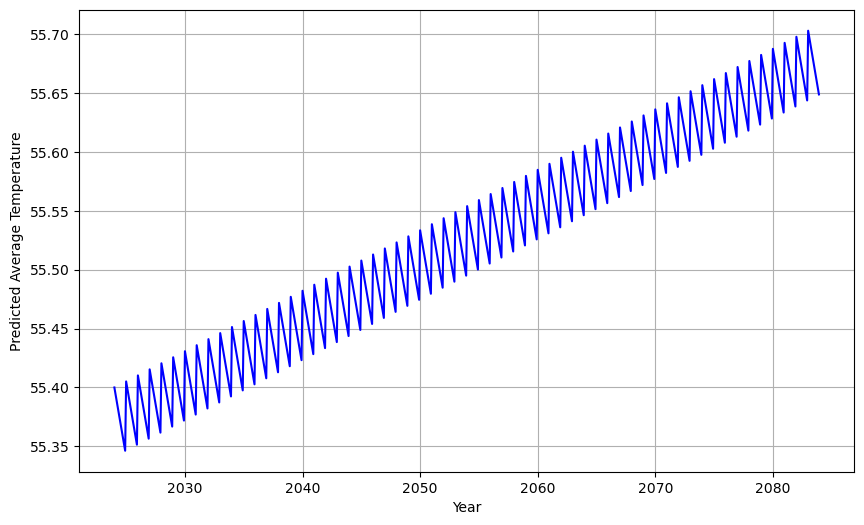

In [27]:
# Flatten predictions
predictions = np.array(predictions).reshape(-1)

# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
offset = 55.4 - predictions[0]
predictions += offset

# Converting the years/months into a float, this is so our x-axis shows the year value, and not how it is stored (202401)
years_float = date_predict[:, 0] + (date_predict[:, 1] - 1) / 12

plt.figure(figsize=(10, 6))
plt.plot(years_float, predictions, color='blue')
plt.xlabel('Year')
plt.ylabel('Predicted Average Temperature')
plt.grid(True)
plt.show()

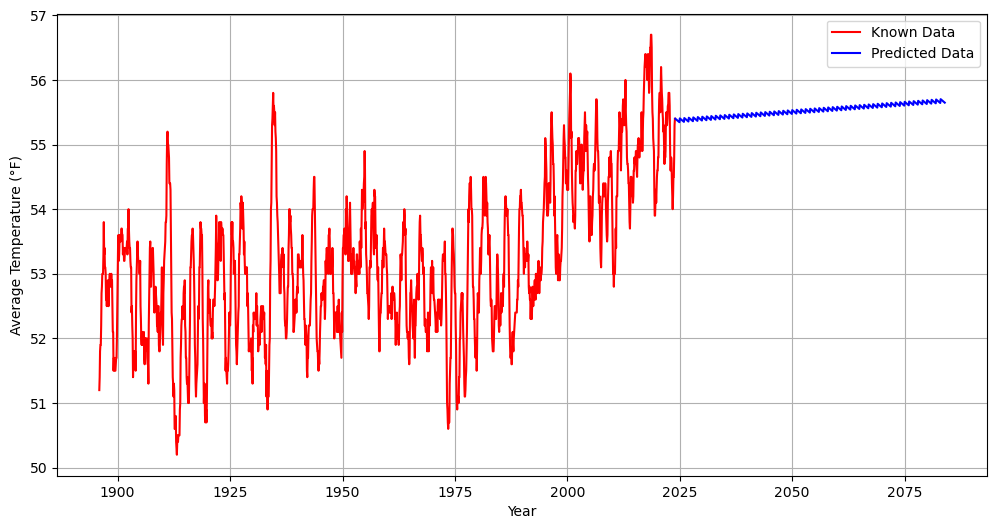

In [28]:
# Read data
known_temperatures = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_avg_temp.csv')
# Rename columns for simplicity
known_temperatures.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
# Drop average temperature anomaly (we don't care about it)
known_temperatures.drop(columns=['avg_temp_anomaly'], inplace=True)
# Convert the 'date' column to datetime variable
known_temperatures['date'] = pd.to_datetime(known_temperatures['date'].astype(str), format='%Y%m')
# Grab the year (decimal years)
known_years_float = known_temperatures['date'].dt.year + (known_temperatures['date'].dt.month - 1) / 12
# All of our previous years' temperatures
known_temperatures_values = known_temperatures['avg_temp']

# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
offset = known_temperatures['avg_temp'].iloc[-1] - predictions[0]  # Align predictions to the last known temperature
predictions += offset  # Apply the offset to the predictions

# Converting the years/months into a float, this is so our x-axis shows the year value, and not how it is stored (202401)
years_float = date_predict[:, 0] + (date_predict[:, 1] - 1) / 12

# Plot
plt.figure(figsize=(12, 6))
plt.plot(known_years_float, known_temperatures_values, color='red', label='Known Data')  # Plot known data in red
plt.plot(years_float, predictions, color='blue', label='Predicted Data')  # Plot predicted data in blue
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()

### RandomForestRegressor & XGBoost Models

Below, we experiment with RandomForestRegressor and XGBoost models.

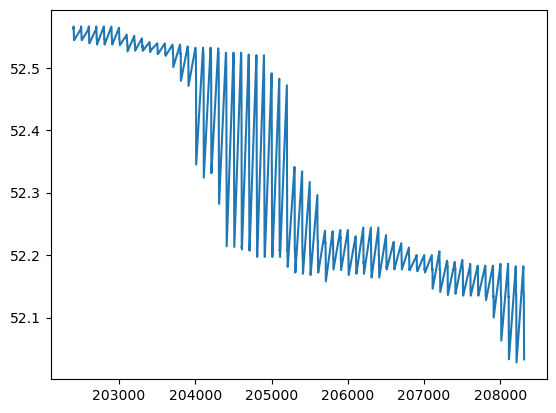

In [29]:
X = data_series[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']]
y = avg_temp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_model.fit(X_train, y_train)

# Create a DataFrame for predicted features
future_predictions = pd.DataFrame(param_predicts.T, columns=columns)

avg_temp_predictions = rf_model.predict(future_predictions)

plt.plot(yearmonth_vec, avg_temp_predictions, label='Predicted Average Temperature (Random Forest)')
plt.show()

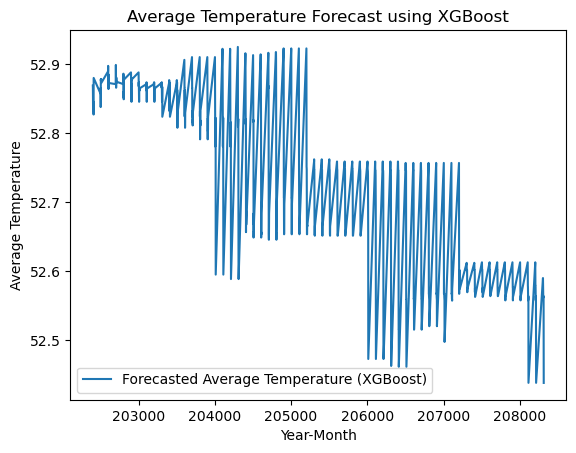

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = data_series[['max_temp', 'min_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']]
y = avg_temp

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)

# Create and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED)  
xgb_model.fit(X_train, y_train)

# Now, to forecast future temperatures, use the `date_predict` and `param_predicts`
# from your existing code to create a DataFrame of future features:

future_predictions = pd.DataFrame(param_predicts.T, columns=columns)

# Make predictions for future dates
future_avg_temp = xgb_model.predict(future_predictions)

# Plot the forecasted values
plt.plot(yearmonth_vec, future_avg_temp, label='Forecasted Average Temperature (XGBoost)')
plt.xlabel("Year-Month")
plt.ylabel("Average Temperature")
plt.title("Average Temperature Forecast using XGBoost")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions for Random Forest model
rf_predictions = rf_model.predict(X_test)

# Predictions for XGBoost
xgb_predictions = xgb_model.predict(X_test)

# Calculate MSE for both models
rf_mse = mean_squared_error(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# Calculate R-squared for both models
rf_r2 = r2_score(y_test, rf_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nRandom Forest Model:")
print("MSE:", rf_mse)
print("R-squared:", rf_r2)

print("\nXGBoost Model:")
print("MSE:", xgb_mse)
print("R-squared:", xgb_r2)


Random Forest Model:
MSE: 0.10033294805194372
R-squared: 0.8396800065758658

XGBoost Model:
MSE: 0.10022362556388434
R-squared: 0.8398546907738993


## Predicting Death Rate

### GRU Model

Load data

In [92]:
# Read data
death_rate_data = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/death_rate.csv',thousands=',').dropna() # Drops NaNs
death_rate_data['Year'] = death_rate_data['Year'].astype(int) # Make sure 'Year' column is an integer

# Below I reload all features again- not necessary
############################
# Load the data sets and combine them into a single usable dataframe called data series
data_series = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_avg_temp.csv')
data_series.columns = ['date', 'avg_temp', 'avg_temp_anomaly']
data_series.drop(columns=['avg_temp_anomaly'], inplace=True)
# append to the dataframe
data_cool_degree = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_cool_degree_days.csv')
data_heat_degree = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_heat_degree_days.csv')
data_max_temp = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_max_temp.csv')
data_min_temp = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_min_temp.csv')
data_palmer_z = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_palmer_z.csv')
data_pdsi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_pdsi.csv')
data_phdi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_phdi.csv')
data_pmdi = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_pmdi.csv')
data_precipitation = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_precipitation.csv')
# Append columns to the data series
data_series['cool_degree_days'] = data_cool_degree['Value']
data_series['heat_degree_days'] = data_heat_degree['Value']
data_series['max_temp'] = data_max_temp['Value']
data_series['min_temp'] = data_min_temp['Value']
data_series['palmer_z'] = data_palmer_z['Value']
data_series['pdsi'] = data_pdsi['Value']
data_series['phdi'] = data_phdi['Value']
data_series['pmdi'] = data_pmdi['Value']
data_series['precipitation'] = data_precipitation['Value']
############################

Format data

In [93]:
# This is important, it extracts the year, and adds it to a new column called 'year'
# We do this so that the two dataframes have the same format for time (death_rate_data only has 'Year')
data_series['year'] = pd.to_datetime(data_series['date'], format='%Y%m', errors='coerce').dt.year
# Now we filter for where both datasets overlap in years (for data_series)
filtered_data_series = data_series[data_series['year'].isin(death_rate_data['Year'])]
# Now we merge the two datasets together, now that they have the same years
death_rate_merged = pd.merge(death_rate_data, filtered_data_series, left_on='Year', right_on='year', how='inner')
# Here we drop the columns related to time, we don't want them for our features or target
death_rate_merged.drop(columns=['date', 'year'], inplace=True)
# Below are our features and target- note, we can include population & births if we so choose, just remove them from the .drop()
death_rate_features = death_rate_merged.drop(columns=['Year', 'Deaths', 'Population', 'Births'])
death_rate_target = death_rate_merged['Deaths'] # 'Deaths' is our target

Scale the data

In [94]:
# Scaling
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(death_rate_features[['max_temp', 'min_temp', 'avg_temp','cool_degree_days', 'heat_degree_days']])
robust_scaler = RobustScaler()
x_train_scaled = np.append(x_train_scaled, robust_scaler.fit_transform(death_rate_features[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
minmax_scaler = MinMaxScaler()
x_train_scaled = np.append(x_train_scaled, minmax_scaler.fit_transform(death_rate_features[['precipitation']]), axis=1)
# Saves scalers for later- reduces variability, ensures consistent transformation
joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(robust_scaler, 'robust_scaler.joblib')
joblib.dump(minmax_scaler, 'minmax_scaler.joblib')

# Expands the shape of the array for manipulation/compatibility purposes
x_train_scaled = np.expand_dims(x_train_scaled, axis=1)
y_train = np.expand_dims(death_rate_target.to_numpy(), axis=1)

Here, we train the GRU model

In [95]:
## Train GRU model for death rate prediction
# 20 neurons; RELU activation function; input_shape=(timesteps, features at each timestep); 1 dense layer (single output/neuron)
model_gru = Sequential([
    GRU(20, activation='relu', input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])),
    Dense(1)  # Output: death rate
])

## Compile the model (configure it for training)
# ADAM optimizer function; mean squared error loss
model_gru.compile(optimizer='adam', loss='mse')

## Fit (train) the model on the dataset
model_gru.fit(x_train_scaled, y_train, epochs=1000, batch_size=1, verbose=0)

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We want to forecast our death rate predictions, to do this, we treat each parameter as a target variable with its own model. Each model specializes in learning the unique characteristics of each parameter (variations in precipitation, temperature, etc.).

In [96]:
# Define parameters to be predicted
parameters = ['max_temp', 'min_temp','avg_temp', 'cool_degree_days', 'heat_degree_days', 'palmer_z', 'pdsi', 'phdi', 'pmdi', 'precipitation']
param_models = []

# Train secondary models for predicting each parameter
# Each parameter is treated as a target variable with its own model
for param in parameters:
    y = death_rate_features[param].to_numpy() # Convert data to numpy array
    date_splice = death_rate_merged[['Year']].to_numpy()  # Use merged data to ensure alignment
    X_train, X_test, y_train, y_test = train_test_split(date_splice, y, test_size=0.2, shuffle=False) # Split into test, train

    # Sequential model
    model = Sequential([
        Dense(5, activation='relu', input_shape=(X_train.shape[1],)),  # Input shape: year data
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=500, batch_size=64, verbose=0)
    param_models.append(model)

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

Here, we predict our parameters (temperature, precipitation, etc.) for the next 60 years on a monthly basis using the pre-trained regression models.

In [97]:
# Predict future parameters
years = 60  # Number of years in the future
date_predict = np.array([[2024 + i] for i in range(years)])  # Generate years for predictions

# Predict future parameters using secondary models
param_predicts = np.zeros((len(parameters), years))
for k, model in enumerate(param_models):
    param_predicts[k, :] = model.predict(date_predict, verbose=0).flatten()

# Convert predictions to a DataFrame
df_predict = pd.DataFrame(param_predicts.T, columns=parameters)

# Normalize predictions using previously fitted scalers
predict_scaled = std_scaler.transform(df_predict[['max_temp', 'min_temp', 'avg_temp', 'cool_degree_days', 'heat_degree_days']])
predict_scaled = np.append(predict_scaled, robust_scaler.transform(df_predict[['palmer_z', 'pdsi', 'phdi', 'pmdi']]), axis=1)
predict_scaled = np.append(predict_scaled, minmax_scaler.transform(df_predict[['precipitation']]), axis=1)
predict_scaled = np.expand_dims(predict_scaled, axis=1)


The predicted parameters for each year are then fed into our GRU model so that we can forecast predictions for 'Deaths'.

In [98]:
# Initialize predictions variable for death rate
predictions = []

# Loop through each year
for i in range(years):
    # Select predictions for all parameters of year 'i' and adjust dimensions
    new_timestep = np.expand_dims(param_predicts[:, i], axis=0)  # Shape: (1, 9)
    new_timestep = np.expand_dims(new_timestep, axis=1)          # Shape: (1, 1, 9)

    new_timestep_repeated = np.repeat(new_timestep, x_train_scaled.shape[0], axis=0)

    # Concatenate to include past data and predicted parameters
    x = np.concatenate([x_train_scaled[:, 1:, :], new_timestep_repeated], axis=1)

    # Use the GRU model to predict based on x (past data + current predictions)
    death_rate_predict = model_gru.predict(x, verbose=0)

    # Append the mean prediction for the current year
    predictions.append(np.mean(death_rate_predict))


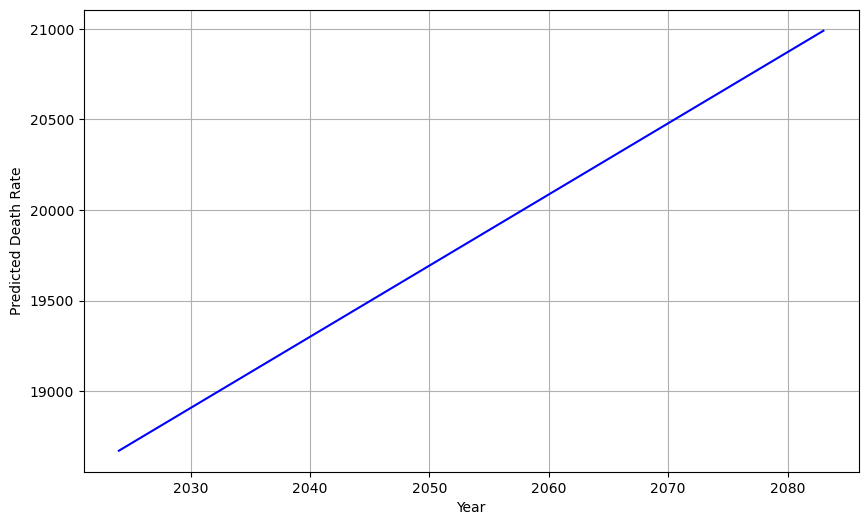

In [99]:
# Here I am applying an offset to stabilize our prediction: in this case it aligns our predictions with the LAST known temperature value
predictions = np.array(predictions) # Convert to array first to apply offset
offset = death_rate_data['Deaths'].iloc[0] - predictions[0]  # Align predictions to the last known temperature
predictions += offset

plt.figure(figsize=(10, 6))
plt.plot(range(2024, 2024 + years), predictions, color='blue')
plt.xlabel('Year')
plt.ylabel('Predicted Death Rate')
plt.grid(True)
plt.show()

### Random Forest Regression

In [100]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_partb.csv')

# Now you can access the columns
df.columns

Index(['Year', 'Population', 'Births', 'Deaths',
       'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)'],
      dtype='object')

In [101]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/lowgard/ml_new_mexico/refs/heads/main/data/data_partb.csv')

# Extract relevant columns and handle missing values
data = data[['Year', 'Population', 'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)', 'Deaths']].dropna()

# Set 'Year' as the index
data.set_index('Year', inplace=True)

# Features and target variable
X = data[['Population', 'CO2 (million metric tons of carbon dioxide)', 'Average Temp (F)']]
y = data['Deaths']  # Replace with 'Birth Rate' if available in your data

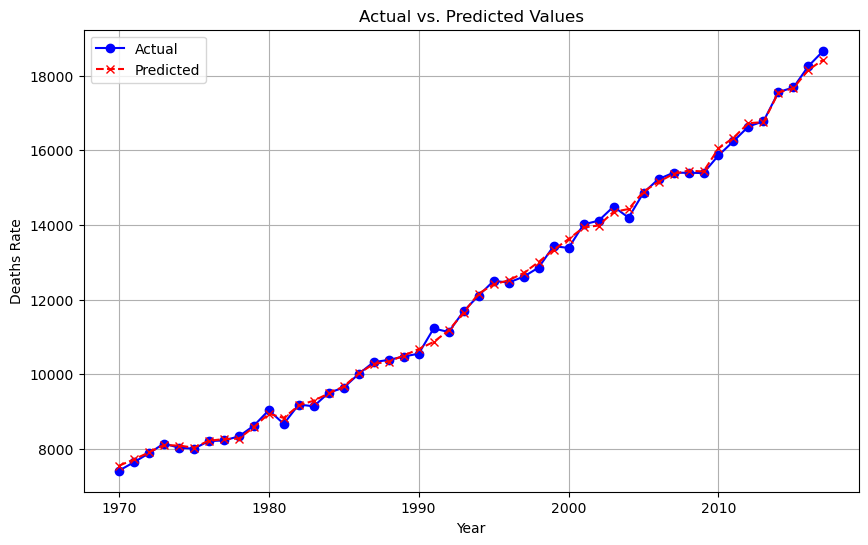

/Users/nicolaaswooters/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


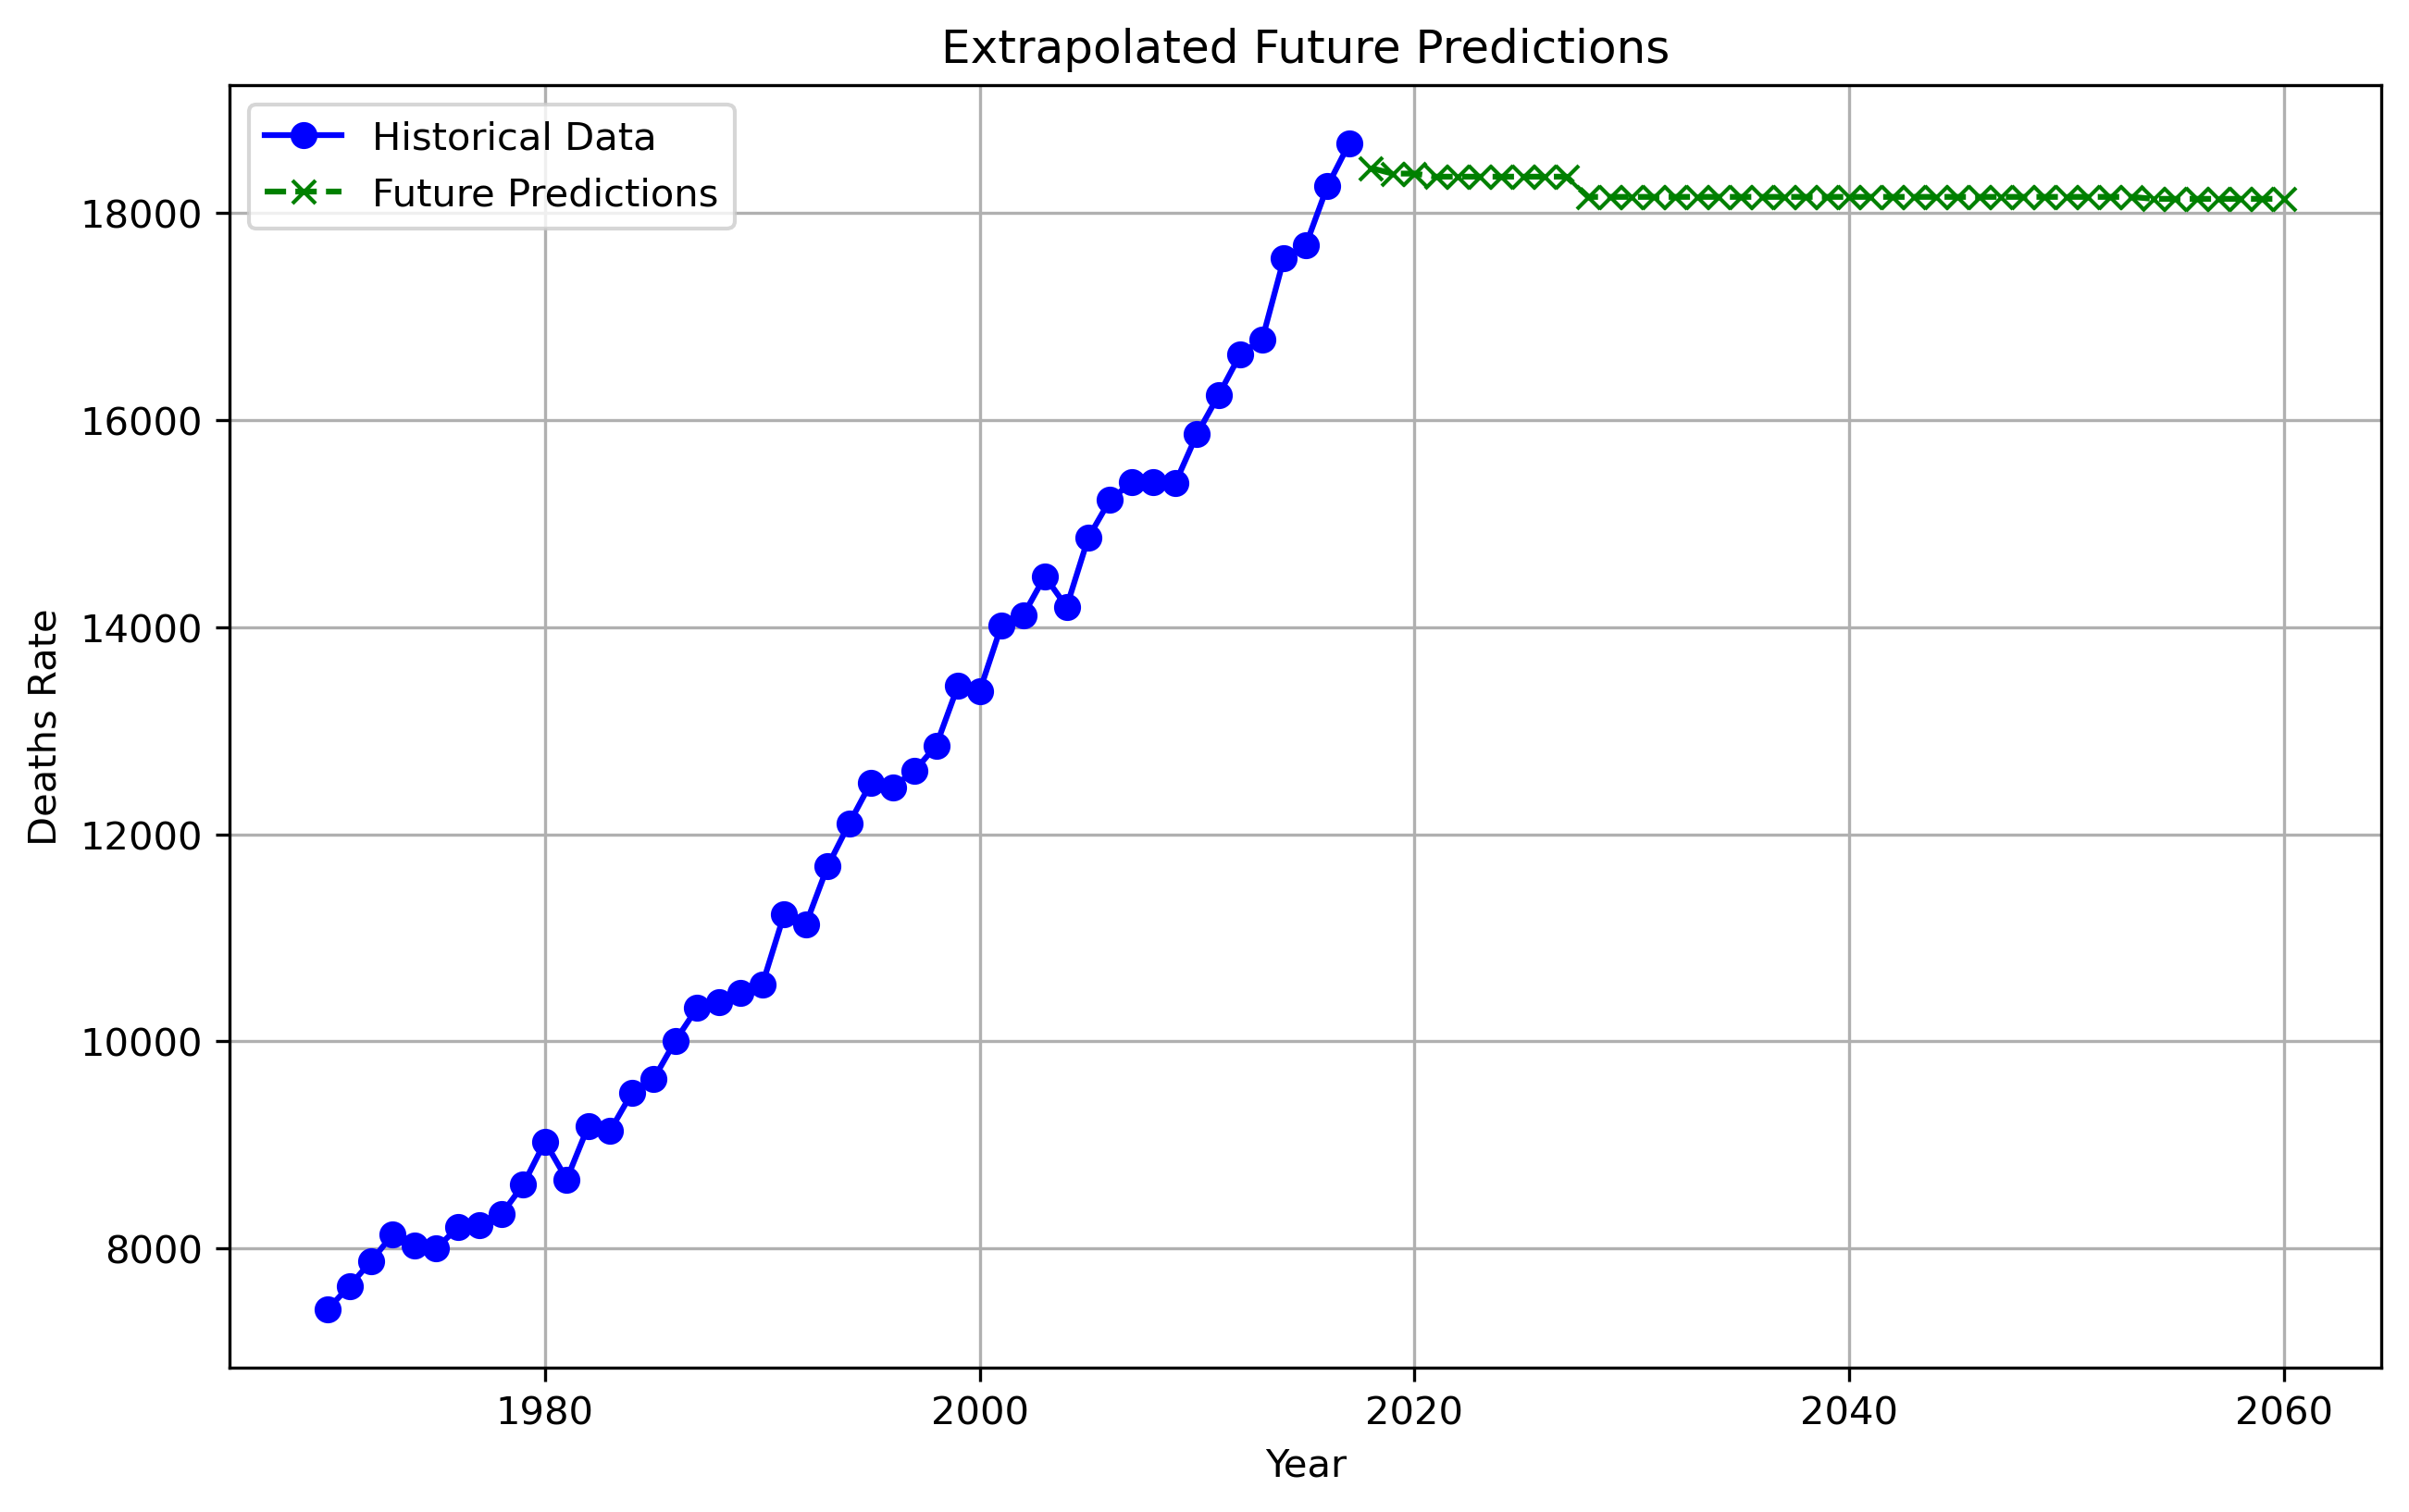

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model to the entire dataset
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_scaled, y)

# Predictions on the full dataset
y_pred = model.predict(X_scaled)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, y, label="Actual", color='blue', marker='o')
plt.plot(data.index, y_pred, label="Predicted", color='red', linestyle='--', marker='x')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Year")
plt.ylabel("Deaths Rate")
plt.legend()
plt.grid()
plt.show()

# Extrapolation: Predict future feature values
future_years = np.arange(2018, 2061)  # Example: Extrapolate for 2018-2061

# Assume linear or polynomial trends for simplicity
future_population = np.linspace(X['Population'].iloc[-1], X['Population'].iloc[-1] * 1.1, len(future_years))
future_CO2 = np.linspace(X['CO2 (million metric tons of carbon dioxide)'].iloc[-1],
                         X['CO2 (million metric tons of carbon dioxide)'].iloc[-1] * 1.05, len(future_years))
future_temp = np.linspace(X['Average Temp (F)'].iloc[-1], X['Average Temp (F)'].iloc[-1] + 2, len(future_years))

# Combine into a future feature matrix
future_data = np.column_stack([future_population, future_CO2, future_temp])

# Scale future data
future_data_scaled = scaler.transform(future_data)

# Predict future target variable
future_predictions = model.predict(future_data_scaled)

# Plot future predictions
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(data.index, y, label="Historical Data", color='blue', marker='o')
plt.plot(future_years, future_predictions, label="Future Predictions", color='green', linestyle='--', marker='x')
plt.title("Extrapolated Future Predictions")
plt.xlabel("Year")
plt.ylabel("Deaths Rate")
plt.legend()
plt.grid()
plt.show()